
PROGRAM STARTED: Tennis Odds Predictor v3.2

   ✓ catboost already installed
   ✓ pandas already installed
   Installing scikit-learn...
   ✓ numpy already installed
   ✓ matplotlib already installed
   ✓ shap already installed
Fitting 3 folds for each of 2 candidates, totalling 6 fits
0:	learn: 0.6668991	total: 94.5ms	remaining: 15m 44s
100:	learn: 0.5563980	total: 8.57s	remaining: 14m
200:	learn: 0.5186214	total: 17.4s	remaining: 14m 8s
300:	learn: 0.4863092	total: 26.2s	remaining: 14m 3s
400:	learn: 0.4567306	total: 35s	remaining: 13m 58s
500:	learn: 0.4327652	total: 43.9s	remaining: 13m 52s
600:	learn: 0.4091265	total: 52.7s	remaining: 13m 43s
700:	learn: 0.3876155	total: 1m 1s	remaining: 13m 36s
800:	learn: 0.3666593	total: 1m 10s	remaining: 13m 28s
900:	learn: 0.3464039	total: 1m 19s	remaining: 13m 19s
1000:	learn: 0.3299571	total: 1m 27s	remaining: 13m 10s
1100:	learn: 0.3133192	total: 1m 36s	remaining: 13m 1s
1200:	learn: 0.2974895	total: 1m 45s	remaining: 12m 53s
1300:	learn:

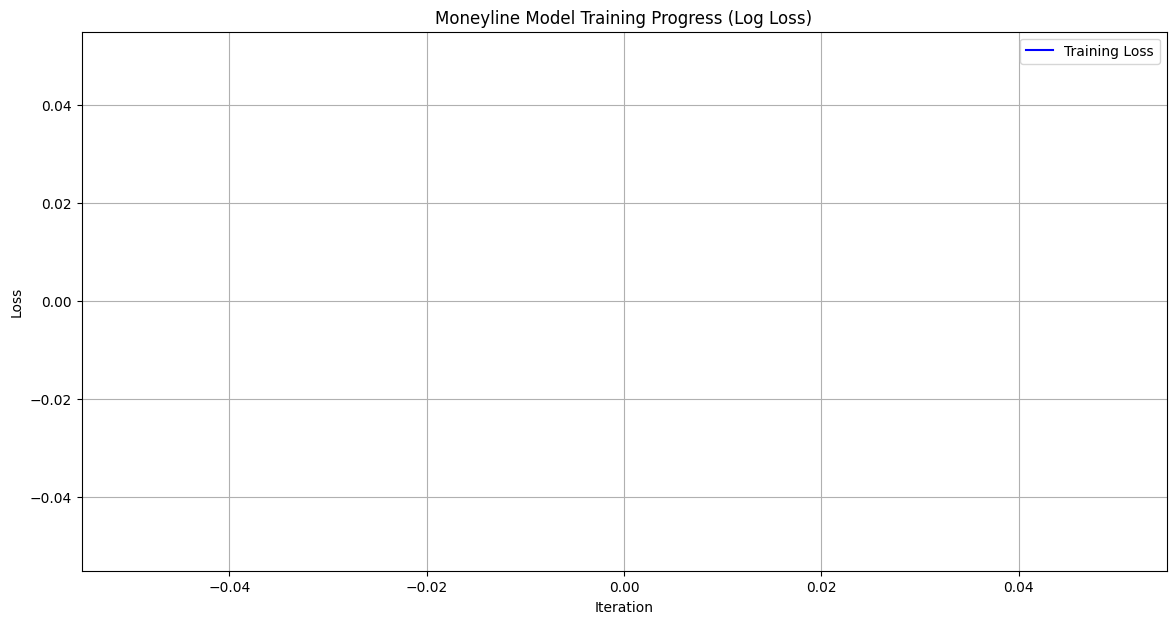

Learning rate set to 0.021736
0:	learn: 5.4856188	test: 5.3343441	best: 5.3343441 (0)	total: 33.9ms	remaining: 5m 39s
100:	learn: 4.8522578	test: 4.7830091	best: 4.7830091 (100)	total: 3.39s	remaining: 5m 32s
200:	learn: 4.8180908	test: 4.7734355	best: 4.7731877 (196)	total: 6.68s	remaining: 5m 25s
300:	learn: 4.8058011	test: 4.7743775	best: 4.7731877 (196)	total: 9.89s	remaining: 5m 18s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 4.773187736
bestIteration = 196

Shrink model to first 197 iterations.


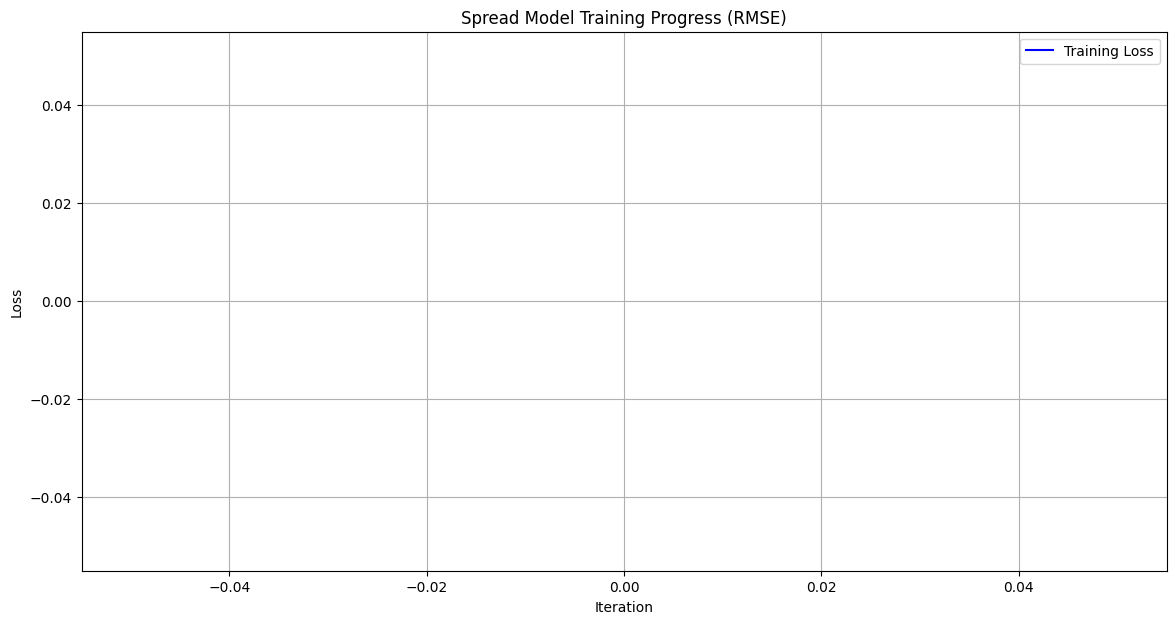

Learning rate set to 0.021736
0:	learn: 0.7432412	test: 0.7821982	best: 0.7821982 (0)	total: 30.3ms	remaining: 5m 2s
100:	learn: 0.5444934	test: 0.5553932	best: 0.5553932 (100)	total: 2.91s	remaining: 4m 45s
200:	learn: 0.5398188	test: 0.5486543	best: 0.5486543 (200)	total: 6.06s	remaining: 4m 55s
300:	learn: 0.5384314	test: 0.5481695	best: 0.5481695 (300)	total: 9.37s	remaining: 5m 1s
400:	learn: 0.5374305	test: 0.5481535	best: 0.5481157 (386)	total: 12.6s	remaining: 5m 2s
500:	learn: 0.5363206	test: 0.5481156	best: 0.5481153 (496)	total: 16s	remaining: 5m 3s
600:	learn: 0.5350260	test: 0.5481687	best: 0.5481153 (496)	total: 19.4s	remaining: 5m 3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5481153099
bestIteration = 496

Shrink model to first 497 iterations.


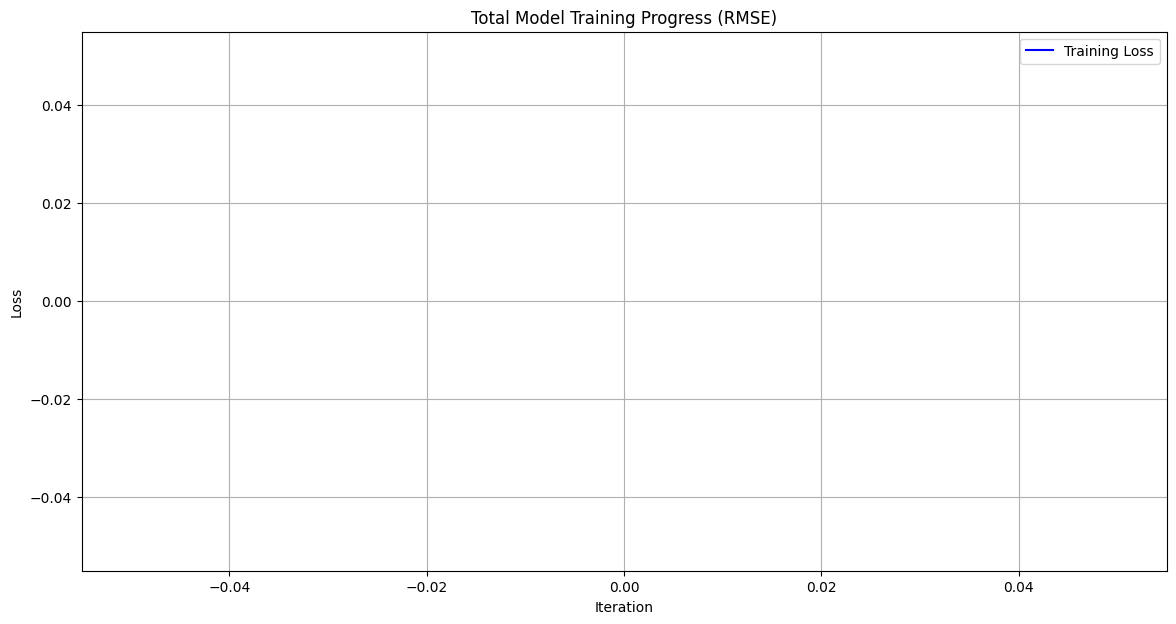


--- Moneyline Model Metrics ---
Log Loss: 0.6156
AUC-ROC: 0.7229
Accuracy: 0.6584

--- Spread Model Metrics ---
RMSE: 4.77
MAE: 4.02

--- Total Model Metrics ---
RMSE: 0.55
R² Score: 0.5181


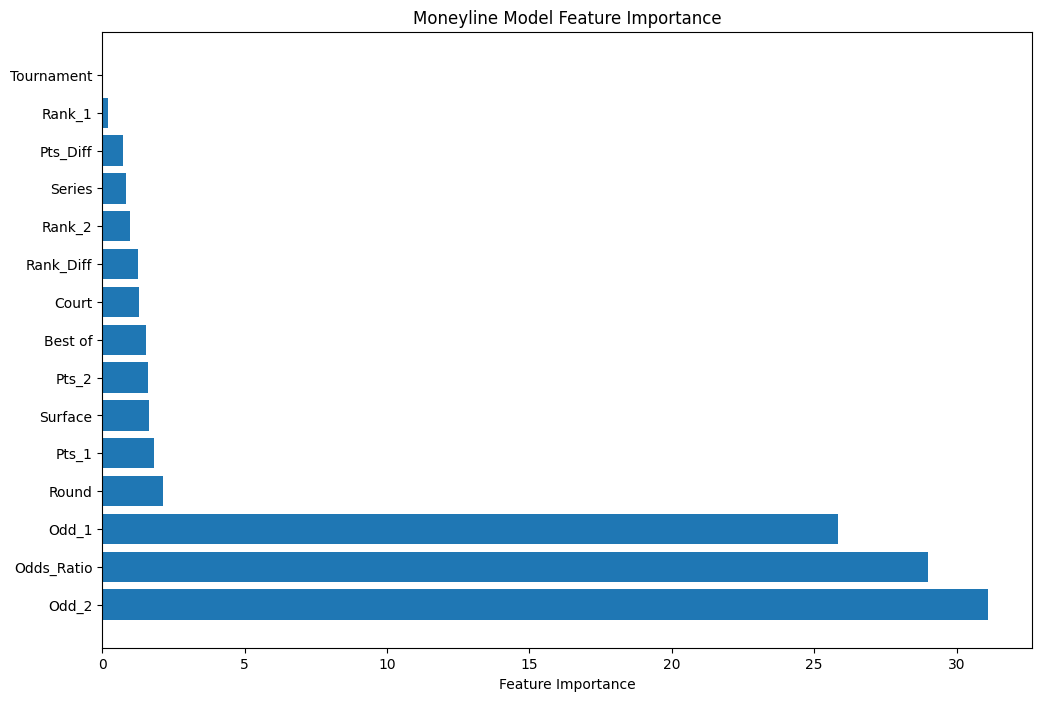

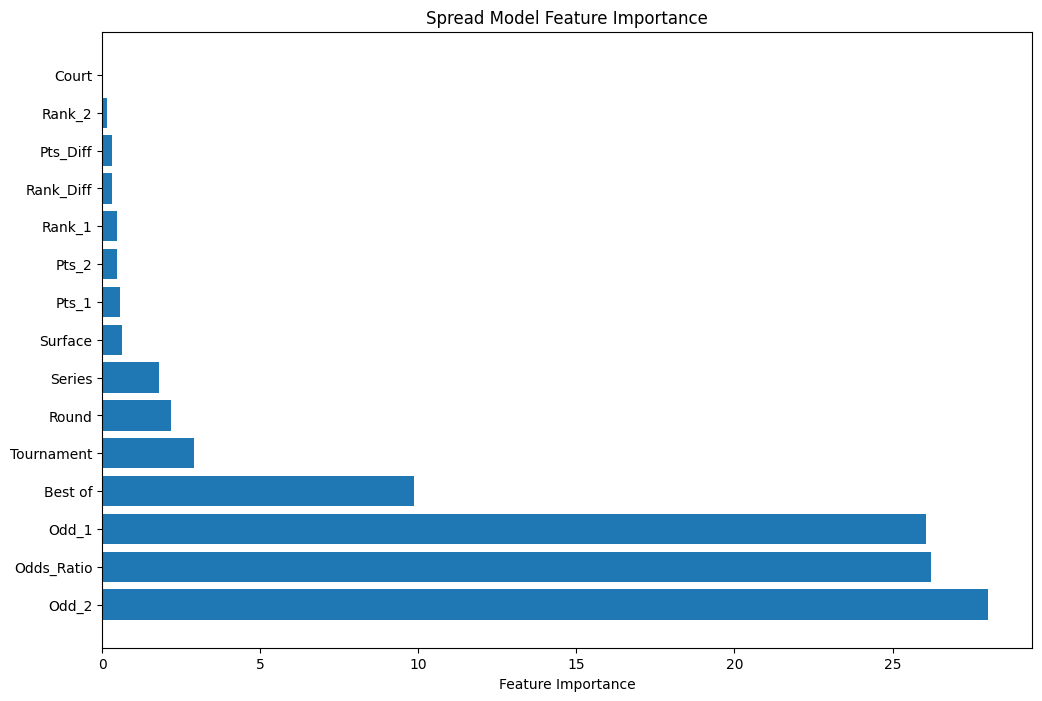

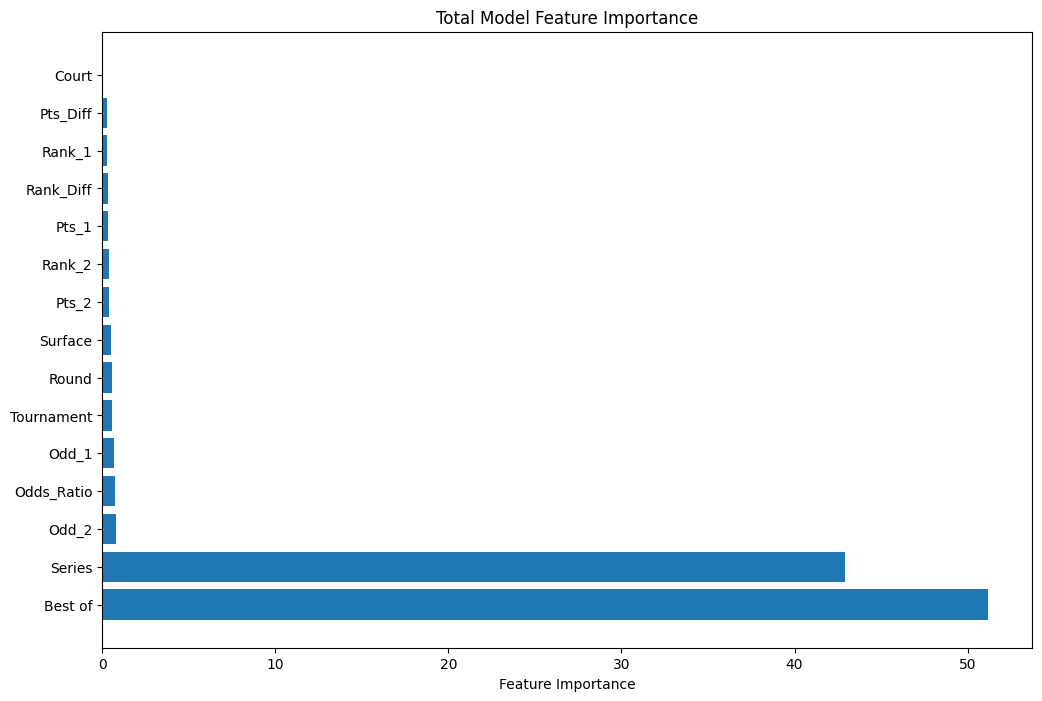

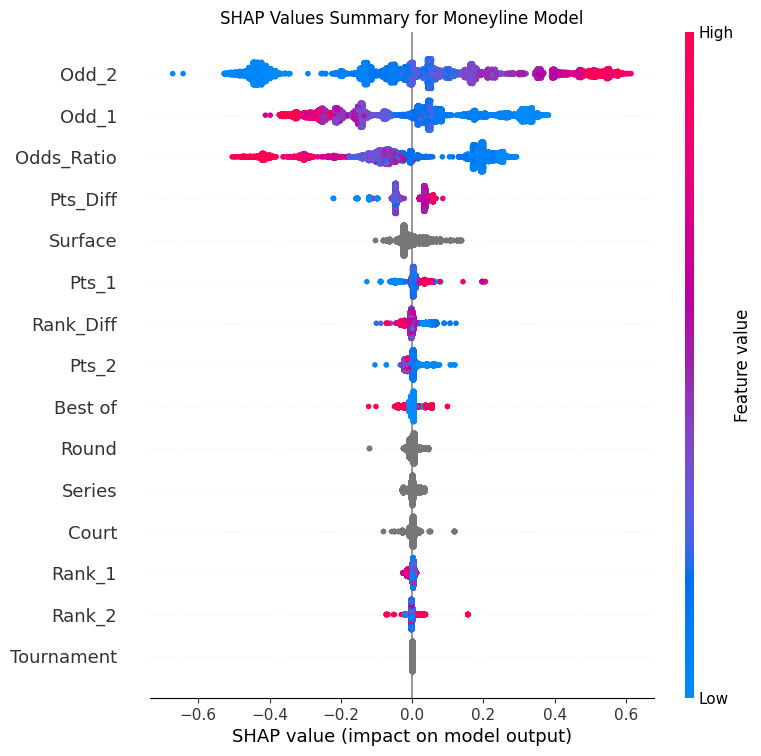

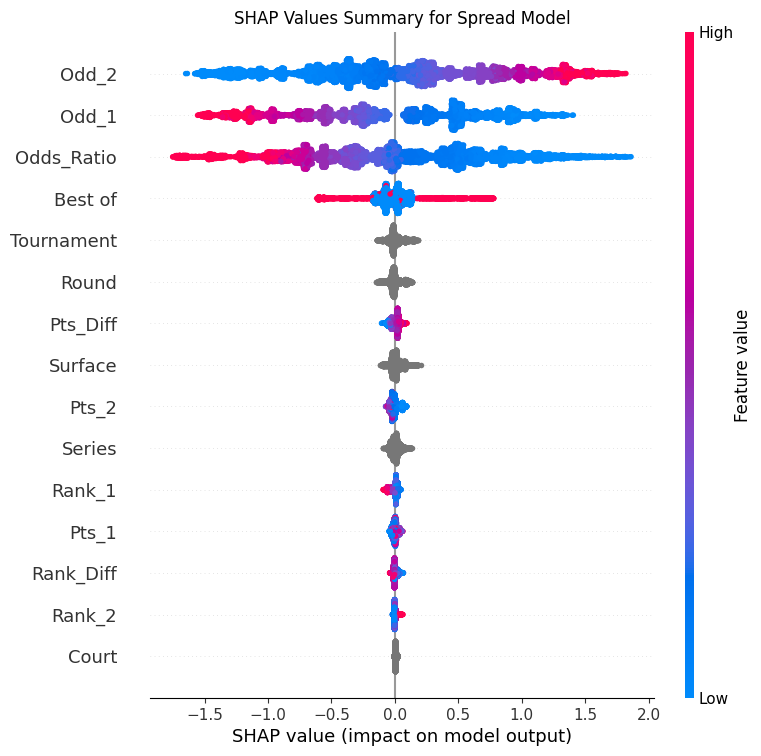

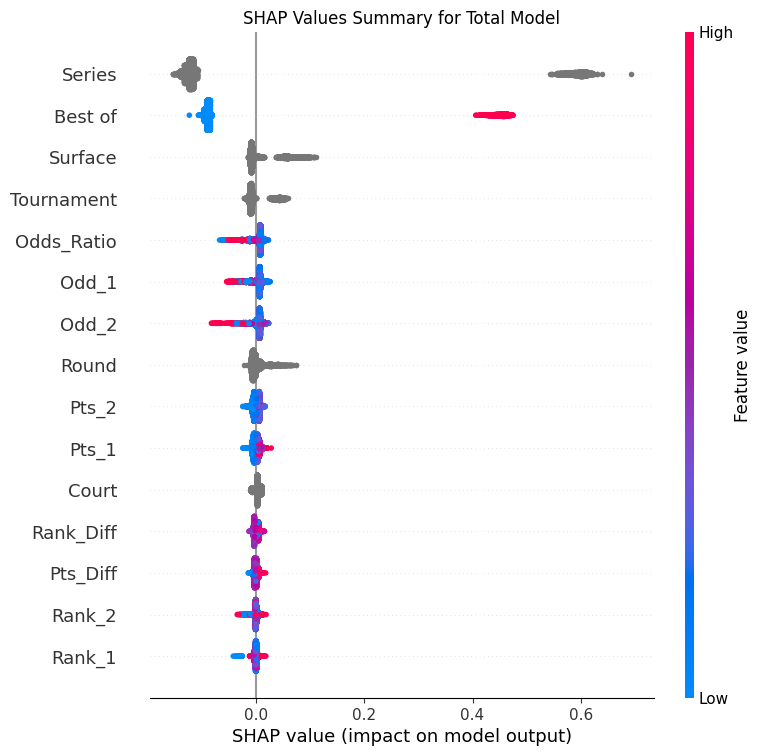


PROGRAM COMPLETED SUCCESSFULLY


In [20]:
# =====================================================================
# TENNIS MATCH ODDS PREDICTION MODEL (OPTIMIZED)
# =====================================================================
import io
import sys
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (mean_squared_error, log_loss, 
                            roc_auc_score, mean_absolute_error, 
                            r2_score)
from sklearn.utils.class_weight import compute_class_weight
import shap
import subprocess
from contextlib import redirect_stderr

# =============================================================================
# Step 1: Setup and Configuration
# =============================================================================
print("\n========================================")
print("PROGRAM STARTED: Tennis Odds Predictor v3.2")
print("========================================\n")

def install(package):
    print(f"   Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = ["catboost", "pandas", "scikit-learn", "numpy", "matplotlib", "shap"]
for pkg in required_packages:
    try:
        __import__(pkg.split('==')[0])
        print(f"   ✓ {pkg} already installed")
    except ImportError:
        install(pkg)

# =============================================================================
# Step 2: Data Loading and Feature Engineering
# =============================================================================
file_path = r"E:\Programs\Models\TennisModel\TrainingData\atp_tennis.csv"
data = pd.read_csv(file_path)

def parse_score(score):
    sets = []
    for s in score.split():
        try:
            games = list(map(int, s.split('-')))
            if len(games) == 2 and all(g >= 0 for g in games):
                sets.append(games)
        except:
            continue
    return sets

def calculate_match_features(row):
    sets = parse_score(row['Score'])
    p1_games = sum(g1 for g1, g2 in sets)
    p2_games = sum(g2 for g1, g2 in sets)
    total_sets = len(sets)
    p1_sets = sum(1 for g1, g2 in sets if g1 > g2)
    p2_sets = total_sets - p1_sets
    max_games = max(max(g1, g2) for g1, g2 in sets) if sets else 0
    return pd.Series([
        p1_games, p2_games, total_sets,
        p1_sets, p2_sets, max_games,
        int(row['Winner'] == row['Player_1'])
    ])

data[['P1_Games', 'P2_Games', 'Total_Sets', 
      'P1_Sets', 'P2_Sets', 'Max_Games', 
      'Player1_Win']] = data.apply(calculate_match_features, axis=1)

data['Spread'] = data['P1_Games'] - data['P2_Games']
data['Rank_Diff'] = data['Rank_1'] - data['Rank_2']
data['Pts_Diff'] = data['Pts_1'] - data['Pts_2']
data['Odds_Ratio'] = data['Odd_1'] / data['Odd_2']

# =============================================================================
# Step 3: Data Preprocessing
# =============================================================================
def remove_outliers(df, columns, threshold=3):
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df = df[z_scores < threshold]
    return df

numeric_cols = ["Rank_1", "Rank_2", "Pts_1", "Pts_2", "Odd_1", "Odd_2"]
data = remove_outliers(data, numeric_cols)
data[numeric_cols] = data[numeric_cols].replace(-1, np.nan)
data = data.dropna()

for col in ["Tournament", "Series"]:
    counts = data[col].value_counts()
    data[col] = data[col].apply(lambda x: x if counts[x] >= 10 else "Other")

predictors = [
    "Tournament", "Series", "Court", "Surface", "Round", "Best of",
    "Rank_1", "Rank_2", "Pts_1", "Pts_2", "Odd_1", "Odd_2",
    "Rank_Diff", "Pts_Diff", "Odds_Ratio"
]

categorical_cols = ["Tournament", "Series", "Court", "Surface", "Round"]

# =============================================================================
# Step 4: Data Splitting
# =============================================================================
train_size = int(len(data) * 0.8)
X_train = data[predictors].iloc[:train_size]
X_test = data[predictors].iloc[train_size:]
y_train_ml = data['Player1_Win'].iloc[:train_size]
y_test_ml = data['Player1_Win'].iloc[train_size:]
y_train_spread = data['Spread'].iloc[:train_size]
y_test_spread = data['Spread'].iloc[train_size:]
y_train_total = data['Total_Sets'].iloc[:train_size]
y_test_total = data['Total_Sets'].iloc[train_size:]

# =============================================================================
# Step 5: Hyperparameter Tuning (Optimized)
# =============================================================================
param_dist = {
    'depth': [6, 8],
    'learning_rate': [0.1, 0.15],
    'l2_leaf_reg': [1, 3]
}

ml_tuning_model = CatBoostClassifier(
    iterations=10000,
    loss_function='Logloss',
    early_stopping_rounds=200,
    verbose=100,
    cat_features=categorical_cols  # Explicitly set categorical features
)

random_search = RandomizedSearchCV(
    ml_tuning_model,
    param_distributions=param_dist,
    n_iter=2,
    cv=3,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

random_search.fit(
    X_train[:50000],
    y_train_ml[:50000]
)

# =============================================================================
# Step 6: Training with Robust Logging
# =============================================================================
def parse_training_logs(logs):
    pattern = re.compile(r'^(\d+):.*\b(learn|test):\s*([\d.]+)', re.MULTILINE)
    matches = pattern.findall('\n'.join(logs))
    
    log_data = {}
    for it, typ, val in matches:
        it = int(it)
        val = float(val)
        if it not in log_data:
            log_data[it] = {'learn': None, 'test': None}
        log_data[it][typ] = val
    
    iterations = []
    learn_loss = []
    test_loss = []
    for it in sorted(log_data.keys()):
        iterations.append(it)
        learn_loss.append(log_data[it]['learn'])
        test_loss.append(log_data[it]['test'])
    
    return iterations, learn_loss, test_loss

def plot_training_progress(iterations, learn, test, title, loss_type):
    plt.figure(figsize=(14, 7))
    
    # Plot training loss
    plt.plot(iterations, learn, label='Training Loss', color='blue')
    
    # Filter and plot validation loss
    valid_test = [t for t in test if t is not None]
    if valid_test:
        valid_indices = [i for i, t in enumerate(test) if t is not None]
        valid_iters = [iterations[i] for i in valid_indices]
        plt.plot(valid_iters, valid_test, label='Validation Loss', color='orange')
    
    plt.title(f'{title} Training Progress ({loss_type})')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Moneyline Model
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1]),
    y=y_train_ml
)

ml_model = CatBoostClassifier(
    **random_search.best_params_,
    iterations=10000,
    early_stopping_rounds=200,
    loss_function='Logloss',
    eval_metric='AUC',
    class_weights=class_weights,
    verbose=100,
    cat_features=categorical_cols
)

ml_buffer = io.StringIO()
with redirect_stderr(ml_buffer):
    ml_model.fit(X_train, y_train_ml, 
                eval_set=(X_test, y_test_ml),
                use_best_model=True)

ml_logs = ml_buffer.getvalue().split('\n')
ml_iters, ml_learn, ml_test = parse_training_logs(ml_logs)
plot_training_progress(ml_iters, ml_learn, ml_test, 'Moneyline Model', 'Log Loss')

# Spread Model
spread_model = CatBoostRegressor(
    iterations=10000,
    early_stopping_rounds=200,
    loss_function='RMSE',
    verbose=100,
    cat_features=categorical_cols
)

spread_buffer = io.StringIO()
with redirect_stderr(spread_buffer):
    spread_model.fit(X_train, y_train_spread,
                    eval_set=(X_test, y_test_spread),
                    use_best_model=True)

spread_logs = spread_buffer.getvalue().split('\n')
spread_iters, spread_learn, spread_test = parse_training_logs(spread_logs)
plot_training_progress(spread_iters, spread_learn, spread_test, 'Spread Model', 'RMSE')

# Total Model
total_model = CatBoostRegressor(
    iterations=10000,
    early_stopping_rounds=200,
    loss_function='RMSE',
    verbose=100,
    cat_features=categorical_cols
)

total_buffer = io.StringIO()
with redirect_stderr(total_buffer):
    total_model.fit(X_train, y_train_total,
                   eval_set=(X_test, y_test_total),
                   use_best_model=True)

total_logs = total_buffer.getvalue().split('\n')
total_iters, total_learn, total_test = parse_training_logs(total_logs)
plot_training_progress(total_iters, total_learn, total_test, 'Total Model', 'RMSE')

# =============================================================================
# Step 7: Model Evaluation
# =============================================================================
# Moneyline Evaluation
y_pred_proba = ml_model.predict_proba(X_test)[:,1]
y_pred_ml = ml_model.predict(X_test)
print("\n--- Moneyline Model Metrics ---")
print(f"Log Loss: {log_loss(y_test_ml, y_pred_proba):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test_ml, y_pred_proba):.4f}")
print(f"Accuracy: {np.mean(y_pred_ml == y_test_ml.values):.4f}")

# Spread Evaluation
y_pred_spread = spread_model.predict(X_test)
print("\n--- Spread Model Metrics ---")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_spread, y_pred_spread)):.2f}")
print(f"MAE: {mean_absolute_error(y_test_spread, y_pred_spread):.2f}")

# Total Evaluation
y_pred_total = total_model.predict(X_test)
print("\n--- Total Model Metrics ---")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_total, y_pred_total)):.2f}")
print(f"R² Score: {r2_score(y_test_total, y_pred_total):.4f}")

# =============================================================================
# Step 8: Model Interpretability
# =============================================================================
def plot_feature_importance(model, title):
    importances = model.get_feature_importance()
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(predictors)[sorted_idx])
    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.show()

plot_feature_importance(ml_model, 'Moneyline Model Feature Importance')
plot_feature_importance(spread_model, 'Spread Model Feature Importance')
plot_feature_importance(total_model, 'Total Model Feature Importance')

# SHAP Visualizations
try:
    # Moneyline SHAP
    explainer_ml = shap.TreeExplainer(ml_model)
    shap_values_ml = explainer_ml.shap_values(X_test)
    plt.figure(figsize=(14, 8))
    shap.summary_plot(shap_values_ml, X_test, feature_names=predictors, show=False)
    plt.title('SHAP Values Summary for Moneyline Model')
    plt.show()
    
    # Spread SHAP
    explainer_spread = shap.TreeExplainer(spread_model)
    shap_values_spread = explainer_spread.shap_values(X_test)
    plt.figure(figsize=(14, 8))
    shap.summary_plot(shap_values_spread, X_test, feature_names=predictors, show=False)
    plt.title('SHAP Values Summary for Spread Model')
    plt.show()
    
    # Total SHAP
    explainer_total = shap.TreeExplainer(total_model)
    shap_values_total = explainer_total.shap_values(X_test)
    plt.figure(figsize=(14, 8))
    shap.summary_plot(shap_values_total, X_test, feature_names=predictors, show=False)
    plt.title('SHAP Values Summary for Total Model')
    plt.show()
except Exception as e:
    print(f"SHAP calculation failed: {str(e)}")

# =============================================================================
# Step 9: Model Export
# =============================================================================
ml_model.save_model('moneyline_model.cbm')
spread_model.save_model('spread_model.cbm')
total_model.save_model('total_model.cbm')

print("\n========================================")
print("PROGRAM COMPLETED SUCCESSFULLY")
print("========================================")